In [69]:
import healpy as hp
import numpy as np
import os
import time
import multiprocessing as mproc
from lsst.daf.persistence import Butler
repo_dir = '/datasets/hsc/repo/rerun/DM-13666/WIDE'
butler = Butler(repo_dir)
#/datasets/hsc/repo/rerun/DM-13666/DEEP/deepCoadd-results/HSC-R

In [70]:
def get_pixel_counts(butler, catalog_name, dataId_list, nside,
                     i_process, out_dict):
    """
    Takes a butler and a list of dataIds and figurs out how many
    stars appear in each healpix
    
    Parameters
    ----------
    butler -- an instance of lsst.daf.persistence.Butler
    
    catalog_name -- the dataset to query (i.e. 'deepCoadd_ref')
    
    dataId_list -- a list of dataIds to process
    
    nside -- the nside of the healpixel grid
    
    i_process -- a unique identifier for this process as called
    from multiprocessing
    
    out_dict -- a multiprocessing.Manager().dict() where we will
    store the output
    
    Returns
    -------
    Nothing
    
    A numpy array corresponding to the number of stars in each
    healpixel is stored in out_dict[i_process]
    """
    
    npix = hp.nside2npix(nside)
    pixel_counts = np.zeros(npix, dtype=int)
    ct = 0
    t_start = time.time()
    for dataId in dataId_list:
        ref_cat = butler.get(catalog_name, dataId=dataId)
        is_primary = ref_cat['detect_isPrimary']
        is_star = ref_cat['base_ClassificationExtendedness_value'] < 0.99
        valid = is_primary & is_star
        data = ref_cat[valid]
        pixel_number = hp.ang2pix(nside,
                                  np.degrees(data['coord_ra']),
                                  np.degrees(data['coord_dec']),
                                  lonlat=True)

        l_pixel_dexes, l_pixel_counts = np.unique(pixel_number,
                                                  return_counts=True)
        pixel_counts[l_pixel_dexes]+=l_pixel_counts
        ct += 1
        if ct %10 ==0:
            duration = time.time()-t_start
            predict = len(dataId_list)*duration/ct
            print('ran %d of %d dataIds; took %.2e sec; total should take %.2e hrs' %
                  (ct, len(dataId_list), duration, predict/3600.0))
    out_dict[i_process] = pixel_counts

In [71]:
nside = 512
npix = hp.nside2npix(nside)
print('resolution %e sq degrees' % (4.0*np.pi*(180.0/np.pi)**2/npix))

resolution 1.311396e-02 sq degrees


In [72]:
pixel_counts = np.zeros(npix, dtype=float)

In [73]:
sky_map = butler.get('deepCoadd_skyMap')

In [74]:
catalog_name = 'deepCoadd_forced_src'
ref_name = 'deepCoadd_ref'
filter_name = 'HSC-R'

In [75]:
tract_root = os.path.join(repo_dir, 'deepCoadd-results', filter_name)
tract_list = os.listdir(tract_root)
tract_list = np.array(tract_list).astype(int)

In [76]:
valid_data_id = []
for tract_id in tract_list:
    tract = sky_map[tract_id]
    patches = tract.getNumPatches()
    for ip1 in range(patches[0]):
        for ip2 in range(patches[1]):
            dataId = {'filter':filter_name,
                      'tract':tract_id,
                      'patch':'%d,%d' % (ip1, ip2)}
            if not butler.datasetExists(catalog_name, dataId=dataId):
                continue
            else:
                valid_data_id.append(dataId)

In [78]:
import copy
print(len(valid_data_id))
valid_data_id_true = copy.deepcopy(valid_data_id)

6965


In [79]:
nside = 512
n_proc = 4
valid_data_id = copy.deepcopy(valid_data_id_true)
manager = mproc.Manager()
pixel_dict = manager.dict()

# just take a random subset
#valid_data_id = np.array(valid_data_id)
#rng = np.random.RandomState(9912)
#rng.shuffle(valid_data_id)
#valid_data_id = valid_data_id[:400]

valid_id_arr = []
butler_arr = []

n_frac = len(valid_data_id)//n_proc

print('n_frac %d len %d' % (n_frac,len(valid_data_id)))

for ii in range(n_proc):
    i_start = ii*n_frac
    i_end = (ii+1)*n_frac
    if ii == n_proc-1:
        i_end=len(valid_data_id)
    local_id_list = valid_data_id[i_start:i_end]
    print(i_start,i_end,len(local_id_list))
    valid_id_arr.append(local_id_list)
    butler_arr.append(Butler(repo_dir))

    #butler, catalog_name, dataId_list, nside,
    #                 i_process, out_dict
    
job_list = []
for ii in range(n_proc):
    p = mproc.Process(target=get_pixel_counts,
                      args=(butler_arr[ii],
                            'deepCoadd_ref',
                            valid_id_arr[ii],
                            nside, ii, pixel_dict))

    p.start()
    job_list.append(p)

for p in job_list:
    p.join()

n_frac 1741 len 6965
0 1741 1741
1741 3482 1741
3482 5223 1741
5223 6965 1742
ran 10 of 1741 dataIds; took 2.84e+01 sec; total should take 1.37e+00 hrs
ran 10 of 1741 dataIds; took 3.38e+01 sec; total should take 1.63e+00 hrs
ran 10 of 1741 dataIds; took 3.68e+01 sec; total should take 1.78e+00 hrs
ran 10 of 1742 dataIds; took 4.89e+01 sec; total should take 2.36e+00 hrs
ran 20 of 1741 dataIds; took 6.20e+01 sec; total should take 1.50e+00 hrs
ran 20 of 1741 dataIds; took 6.58e+01 sec; total should take 1.59e+00 hrs
ran 20 of 1741 dataIds; took 7.60e+01 sec; total should take 1.84e+00 hrs
ran 30 of 1741 dataIds; took 9.59e+01 sec; total should take 1.55e+00 hrs
ran 20 of 1742 dataIds; took 9.93e+01 sec; total should take 2.40e+00 hrs
ran 30 of 1741 dataIds; took 1.02e+02 sec; total should take 1.65e+00 hrs
ran 30 of 1741 dataIds; took 1.08e+02 sec; total should take 1.75e+00 hrs
ran 40 of 1741 dataIds; took 1.31e+02 sec; total should take 1.58e+00 hrs
ran 40 of 1741 dataIds; took 1.41e

In [80]:
for ii in range(n_proc):
    assert len(pixel_dict[ii])==len(pixel_dict[0])

pixel_counts = np.zeros(len(pixel_dict[0]), dtype=int)
for ii in range(n_proc):
    pixel_counts += pixel_dict[ii]

npix = hp.nside2npix(nside)
sq_degrees = 4.0*np.pi*(180.0/np.pi)**2/npix
pixel_counts = pixel_counts.astype(float)/sq_degrees
print(sq_degrees)

0.013113963206424483


In [81]:
%matplotlib inline

In [82]:
import matplotlib.pyplot as plt

In [83]:
valid_pixels = np.where(pixel_counts>0.0)

In [84]:
ra_arr, dec_arr = hp.pix2ang(nside, range(len(pixel_counts)),lonlat=True)

In [85]:
valid_ra = ra_arr[valid_pixels]
valid_dec = dec_arr[valid_pixels]
valid_counts = pixel_counts[valid_pixels]

ra_min = valid_ra.min()
ra_max = valid_ra.max()
dec_min = valid_dec.min()
dec_max = valid_dec.max()

In [61]:
print(ra_min,ra_max)
print(dec_min,dec_max)

29.003906249999996 341.455078125
-7.331168113595439 53.09094829504232


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


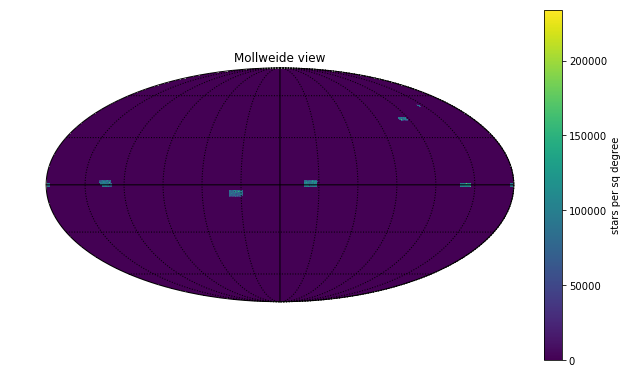

In [86]:
hp.mollview(pixel_counts, cbar=False,
                        flip='astro',
                        return_projected_map=True)
hp.graticule()
ax = plt.gca()
im = ax.get_images()[0]
plt.colorbar(im,label='stars per sq degree')